# Classifier Training Example

In this example we train a multi-class classifier.  The reading of input data, torch data set provider and the model definition are provided by imported modules.

The raw input data is simply a binary blob of several hundred thousand `np.float32` values in the range \[-1.0, 1.0\). Their meaning is defined by a function in  the `dataprovider` module (users can supply their own callables). More specifically, the numbers are interpreted as cartesian (x1, x2) coordinates.  

The function `truth_labels_unit_circle` in the `dataprovider` module defines three classes for the (x1, x2) tuples:

 1. points outside the unit circle `r = sqrt(x1*x1 + x2*x2) >= 1` (this is considered 'background')
 2. points in the unit circle with `x2 <= 0.0` (this is considered 'signal 1')
 3. points in the unit circle with `x2 > 0.0` (this is considered 'signal 2')
 
The truth labels are therefore one-hot vectors of dimension 3.  The `dataprovider` dynamically generates the truth labels using the above definition. That is, the truth labels are not stored in the data file, allowing you to use the same data to experiment with different classification problems by simply supplying an appropriate function. In your application the truth lables are likely to be derived from the labeled input data (MC sample). That is not a problem -- simply provide a callable that generates them from your event structure and you are all set.

The way the data is read from the file is unecessarily complicated for this simple example. We define a generator function that reads (x1, x2) pairs one-by-one from the file and then re-assemble the points into `np.arrays` and `torch.tensors`.  We could just directly read the whole binary blob into an `np.array` or `torch.tensor` and then reshape it to our needs. However, real life data sets are rarely that easy to access and we would like to provide examples of all necessary components to read more complicated event-oriented data (here an "event" is just an (x1, x2) pair).

The classifier model is a fully-connected feed-forward neural network. The network layout (number of hidden layers etc. is specified when the model instance is constructed. This makes it straight forward to try different network layouts. The number of input and output nodes must always match the dimension of the parameter space and the number of classes, respectively.

We encourage you to experiment with different class definitions, network layouts and other meta parameters. Note that the default classes in this example ensure a reasonably balanced number of class instances.  This is important: if your real life data set is highly imbalanced (e.g. much more background than signal) you *should enforce a balanced data set for training*.

Make sure you have a good look at the `dataprovider` and `classification` modules and try to understand what they do.  The `dataprovider` module is not specific to PyTorch in any way -- it is just an example with all the necessary hooks to implement your own data provider suitable for your data source. Read the applicaple PyTorch documentation for the code in the `classification` module.

### Documentation
[Modules Tutorial](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html)

[NN Reference](https://pytorch.org/docs/stable/nn.html)

#### Setup
Import the required modules and make sure our (and only our!) modules are
reloaded before code execution.

In [2]:
%reload_ext autoreload
%aimport dataprovider, classification
%autoreload 1

# framework modules
import matplotlib.pyplot as plt
import torch
import torch.utils.data as utils_data
import torch.nn as nn

# our modules
import dataprovider as dp
import classification as cl

#### Data Sets
Here we generate a binary file with a data set for training and provide PyTorch data sets for training and validation by reading the file. The file reading is handled by a generator function in the `dataprovider` module which provides an iterator over 'events' in the file.

When training classifiers it is quite important to have a reasonably balanced data set. That is, all classes should be represented in roughly equal proportions -- if the data set is, say, completelely dominated by background the NN will just learn that there is no signal.

In order not to make the example too complicated, we do not take any special measures to ensure this balance as the example data set is roughly balanced by its definition and generation.

We split the labeled data sample in a training an validation sample. This can be done in various ways. Here we simply read distinct events from the generated binary file. However you do this, it is important that the training and validation data sets are distinct.

In [3]:
data_file_path = './training_data.bin'
dp.generate_data(data_file_path, force=False)
num_events = 20000
validation_fraction = 0.2
num_training_events = int(num_events * (1 - validation_fraction))
num_validation_events = num_events - num_training_events
training_events = dp.events(data_file_path, evt_max=num_training_events)
training_dataset = cl.LabeledDataset(training_events,
                                     var_generator=dp.event_to_values,
                                     label_generator=dp.truth_labels_unit_circle) 
validation_events = dp.events(data_file_path, evt_max=num_validation_events, evt_skip=num_training_events)
validation_dataset = cl.LabeledDataset(validation_events,
                                       var_generator=dp.event_to_values,
                                       label_generator=dp.truth_labels_unit_circle) 

The file './training_data.bin' already exists, no data generated. Use force=True to regenerate.


#### A Peep at the Data

Let's have a quick look at the data provided by the validation data set (the format is the same for the training data set). We see that the `LabeledDataset` class provides a tuple of of `torch.tensor` representations. The first entry contains the values corresponding to the event and the second contains the associated truth labels.

In [4]:
print('Number of events in validation data set: {}'.format(len(validation_dataset)))
print(validation_dataset[:1000])

Number of events in validation data set: 4000
(tensor([[ 0.9223,  0.0071],
        [-0.9940,  0.5725],
        [ 0.9699, -0.5333],
        ...,
        [ 0.5565,  0.6467],
        [-0.2740,  0.2507],
        [-0.5386, -0.5599]]), tensor([[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]]))


#### A Graphical Look at the Data
Now let's make a plot: we'll make a scatter plot color-coded by the truth labels in the validation data set.

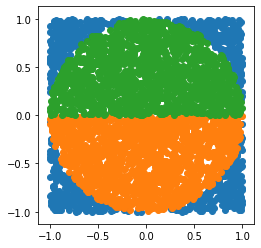

In [5]:
xs = validation_dataset.xs
ys = validation_dataset.ys
bg_idxs = ys[:,0].nonzero()
s1_idxs = ys[:,1].nonzero()
s2_idxs = ys[:,2].nonzero()

plt.axes().set_aspect('equal')
plt.scatter(xs[:,0][bg_idxs], xs[:,1][bg_idxs])
plt.scatter(xs[:,0][s1_idxs], xs[:,1][s1_idxs])
plt.scatter(xs[:,0][s2_idxs], xs[:,1][s2_idxs])
plt.show()

#### Training

We configure the the network layout and the PyTorch 
data loader instances.  The network takes two input
variables, three outputs corresponding to the three classes and two
hidden layers. The network is very small because the classification problem
is very simple and we want to see womething not quite perfect in the evaluation
plots (separate notebook).  That is, we deliberately limit the network to
make the example more interesting.
You should experiment with different network layouts and 
learning rates in the optimizer. Observe how stable you training is by running it several
times in the same configuration.

The training loop monitors the test loss at the end of each epoch. If there
is nothing more to learn (the loss does not significantly decrease over several epochs)
the training finishes.

In [ ]:
classifier_nn = cl.ClassifierNN(layout=(2, 5, 7, 3))
classifier_nn.train()
print(classifier_nn)

batch_size = 64
train_loader = utils_data.DataLoader(training_dataset,
                                     batch_size=batch_size,
                                     shuffle=True)
test_loader = utils_data.DataLoader(validation_dataset,
                                     batch_size=batch_size,
                                     shuffle=True)

max_epochs = 200
min_gain = 0.01
grace_limit = 4
grace = 0
learning_rate = 0.002
train_history = []
test_history = []
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(classifier_nn.parameters(),
                             lr=learning_rate, 
                             weight_decay=1e-5)

best_loss = 1.0
for epoch in range(max_epochs):
    mean_train_loss = 0.0
    for i, (xs, ys) in enumerate(train_loader):
        optimizer.zero_grad() # reset gradients
        outputs = classifier_nn(xs) 
        train_loss = loss_function(outputs, ys)
        train_loss.backward() # gradient back propagation
        optimizer.step()
        mean_train_loss = (mean_train_loss * i + train_loss.item()) / (i + 1)
    train_history.append(mean_train_loss)
    
    mean_test_loss = 0.0
    for i, (xs, ys) in enumerate(test_loader):
        outputs = classifier_nn(xs)
        eval_loss = loss_function(outputs, ys)
        mean_test_loss = (mean_test_loss * i + eval_loss.item()) / (i + 1)
    test_history.append(mean_test_loss)
    
    print('Epoch {}, mean train/test loss: {:.4f}/{:.4f}'.format(epoch, mean_train_loss, mean_test_loss))
    if (best_loss - mean_test_loss) / best_loss < min_gain:
        if grace == 0:
            print('Entering grace period (limit {})'.format(grace_limit))
            grace += 1
        elif grace < grace_limit:
            grace += 1
        else:
            print('Nothing more to learn. Training finished.')
            break
    else:
        if grace > 0:
            grace = 0
            print('Survived grace period.')
        best_loss = mean_test_loss
else:
    print('Maximum number of epochs ({}) reached. Training terminated.'.format(max_epochs))

weight_path = classifier_nn.save_weights(tag='example1', time_stamp=False)
print("Saved network parameters to '{}'.".format(weight_path))

In [ ]:
plt.figure()
plt.plot(train_history, label='Training Loss')
plt.plot(test_history, label='Test Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
